In [29]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


In [30]:
datadir = '/Users/kesavreddy/Downloads/DataJPG'


In [31]:
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]

category_counts = pd.DataFrame({'Category': category_dirs,'Count': [len(os.listdir(os.path.join(datadir, d))) for d in category_dirs]})

In [32]:
category_counts

,Category,Count
0,G,28
1,A,127
2,E,3
3,B,18


In [33]:
img_size = 299  # InceptionV3 input size is 299x299
batch_size = 32
num_classes = 4

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 42526 files belonging to 4 classes.
Using 34021 files for training.
Found 42526 files belonging to 4 classes.
Using 8505 files for validation.


In [35]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


In [36]:
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [37]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/15


2023-11-15 00:07:23.295697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - ETA: 0s - loss: 2.6077 - accuracy: 0.6273

2023-11-15 00:09:58.631041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - 195s 180ms/step - loss: 2.6077 - accuracy: 0.6273 - val_loss: 3.4108 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 2/15
1064/1064 [==============================] - 189s 178ms/step - loss: 1.5010 - accuracy: 0.6669 - val_loss: 1.5193 - val_accuracy: 0.7096 - lr: 0.0010
Epoch 3/15
1064/1064 [==============================] - 189s 178ms/step - loss: 1.2619 - accuracy: 0.6884 - val_loss: 1.0302 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 4/15
1064/1064 [==============================] - 189s 178ms/step - loss: 1.1644 - accuracy: 0.6972 - val_loss: 1.2138 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 5/15
1064/1064 [==============================] - 189s 177ms/step - loss: 1.1028 - accuracy: 0.7080 - val_loss: 1.1906 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 6/15
1064/1064 [==============================] - 189s 177ms/step - loss: 1.0507 - accuracy: 0.7182 - val_loss: 1.2391 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 7/15
1064/1064 [=======================

In [38]:
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)

266/266 [==============================] - 38s 143ms/step - loss: 0.9345 - accuracy: 0.7700
Test accuracy: 0.7700176239013672


In [39]:
import matplotlib.pyplot as plt

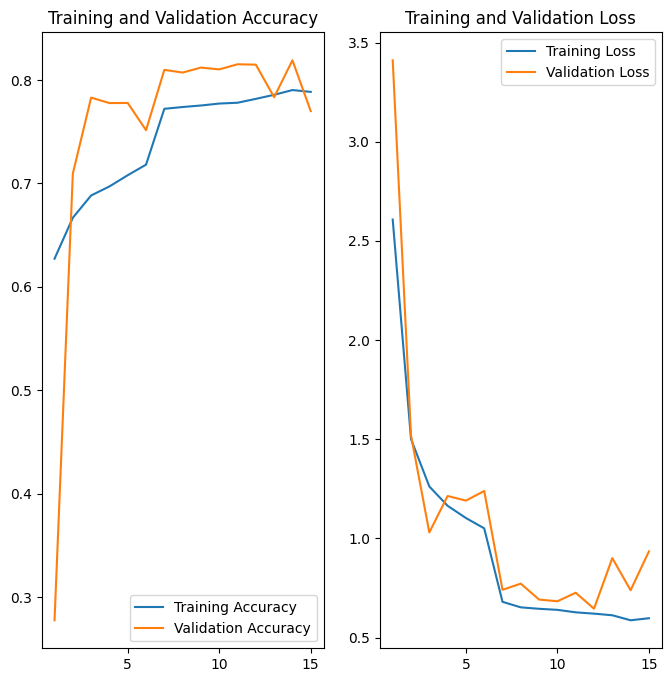

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix for the undefined 'epochs' variable
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
class_names = {
    0: "Adinocarcinoma",
    1: "Small Cell Carcinoma",
    2: "Large Cell Carcinoma",
    3: "Squamous Cell Carcinoma"
}

In [42]:
val_pred_class_names = [class_names[label] for label in val_pred_labels]
val_true_class_names = [class_names[label] for label in val_true_labels]

# Print the predicted class names
for i in range(len(val_pred_class_names)):
    print(f"Predicted: {val_pred_class_names[i]}, Actual: {val_true_class_names[i]}")


Predicted: Adinocarcinoma, Actual: Small Cell Carcinoma
Predicted: Small Cell Carcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Squamous Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Squamous Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Small Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Small Cell Carcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Squamous Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Small Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocar

In [ ]:
val_pred_class_names = [class_names[label] for label in val_pred_labels]
val_true_class_names = [class_names[label] for label in val_true_labels]

# Print the predicted class names
for i in range(len(val_pred_class_names)):
    print(f"Predicted: {val_pred_class_names[i]}, Actual: {val_true_class_names[i]}")


In [43]:
val_pred = model.predict(val_ds)
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)

print("F1 score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))
print("Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(val_true_labels, val_pred_labels))

2023-11-15 00:57:29.566460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


266/266 [==============================] - 39s 142ms/step
F1 score: 0.6168137941245643
Recall: 0.7060552616108172
Confusion Matrix:
 [[5938    0    1  267]
 [ 651    0    0   27]
 [  24    0    0    1]
 [1529    0    0   67]]


In [44]:
model.save("InceptionV3.h5")
print("Model saved successfully.")

/Users/kesavreddy/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [51]:
from PIL import Image
import numpy as np

image_path = '/Users/kesavreddy/Downloads/DataJPG/G/Lung_Dx-G0046jpg/1-002.jpg'  
user_image = Image.open(image_path)
user_image = user_image.resize((299, 299))  

user_image_array = np.array(user_image.convert('RGB')) / 255.0 
user_image_array = np.expand_dims(user_image_array, axis=0)  

user_image_prediction = model.predict(user_image_array)

predicted_class_index = np.argmax(user_image_prediction)
predicted_class_name = class_names[predicted_class_index]

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 37ms/step
Predicted class: Squamous Cell Carcinoma
